In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.neural_network import *
from sklearn.metrics import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import torch
from torch import nn

from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms, utils
from torchvision.transforms import v2
from sklearn.metrics import accuracy_score, confusion_matrix

from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

#Loading numpy
from numpy import load

Using device: cuda


c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may

### NN model for OCTMNIST

In [2]:
DATASET_PATH ='./OCTMNIST/octmnist.npz'

In [3]:
dataset = load(DATASET_PATH)
print(dataset.files)

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


In [4]:
x_train, y_train = dataset['train_images'], dataset['train_labels']
x_val, y_val = dataset['val_images'], dataset['val_labels']
x_test, y_test = dataset['test_images'], dataset['test_labels']

print('x train shape = ', x_train.shape)
print('y train shape = ', y_train.shape)
print('x valid shape = ', x_val.shape)
print('y valid shape = ', y_val.shape)
print('x test shape = ', x_test.shape)
print('y test shape = ', y_test.shape)
num_class = len(np.unique(y_train))
print("num class = ", num_class)

x train shape =  (97477, 28, 28)
y train shape =  (97477, 1)
x valid shape =  (10832, 28, 28)
y valid shape =  (10832, 1)
x test shape =  (1000, 28, 28)
y test shape =  (1000, 1)
num class =  4


### Print sample images

(97477, 28, 28)


c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


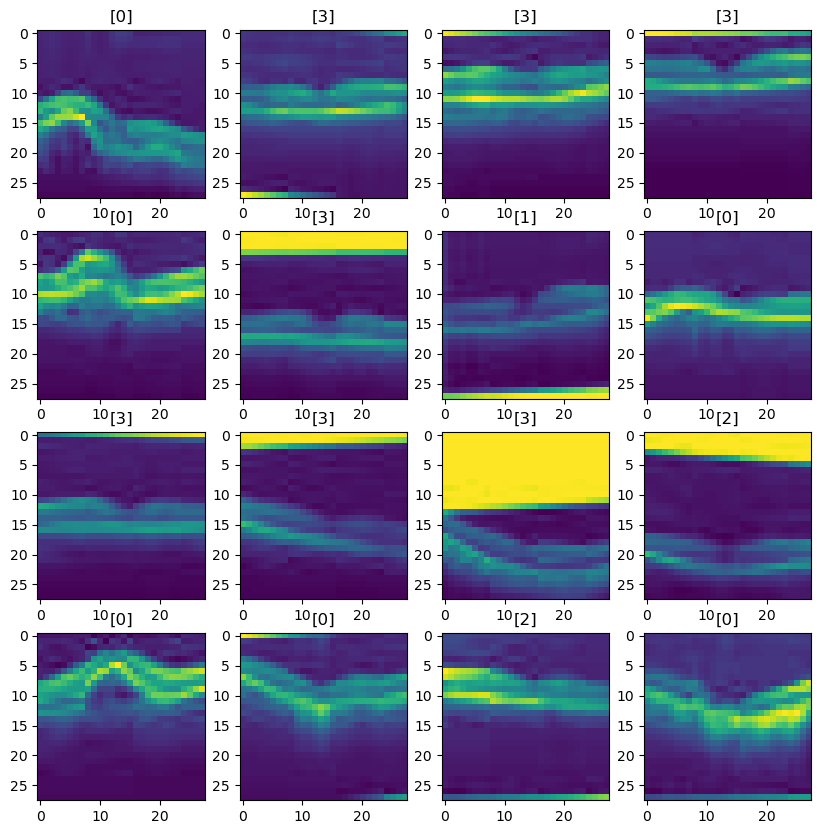

In [5]:
fig, axes = plt.subplots(4,4, figsize = (10,10))
i = 0
print(x_train.shape)
for r in range(4):
    for c in range(4):
        axes[r,c].imshow(x_train[i])
        axes[r,c].set_title(y_train[i])
        i += 1

### Building a CNN 

In [6]:
a = torch.rand(100,24,24).unsqueeze(1)
print(a.shape)

torch.Size([100, 1, 24, 24])


In [7]:
class OCTMNISTDataset(Dataset):
  def __init__(self, x_train, y_train, device, transforms):
    self.x = torch.tensor(x_train, device = device).type(torch.float).unsqueeze(1)
    self.y = torch.tensor(y_train, device = device).type(torch.long).squeeze(-1)
    self.transforms = transforms

  def __getitem__(self, index):
    return self.transforms(self.x[index]), self.y[index]

  def __len__(self):
    return len(self.x)

  def get_dataloader(self, batch_size = 64, is_test = False):
    if is_test:
      batch_size = len(self.x)
    dataloader =  DataLoader(self, batch_size = batch_size, shuffle = True)
    return dataloader

transforms = v2.Compose([
  v2.RandomHorizontalFlip(0.5),
  v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  v2.Grayscale(1),
])

train_dataset = OCTMNISTDataset(x_train, y_train, DEVICE, transforms = transforms)
train_dataloader = train_dataset.get_dataloader()
print('train_dataloader len =', len(train_dataloader))
val_dataset = OCTMNISTDataset(x_val, y_val, DEVICE, transforms = transforms)
val_dataloader = val_dataset.get_dataloader()
print('val_dataloader len =', len(val_dataloader))
test_dataset = OCTMNISTDataset(x_test, y_test, DEVICE, transforms = transforms)
test_dataloader = test_dataset.get_dataloader(is_test=True)
print('test_dataloader len =', len(test_dataloader))

train_dataloader len = 1524
val_dataloader len = 170
test_dataloader len = 1


image shape  torch.Size([64, 1, 28, 28])
label shape  torch.Size([64])
(97477, 28, 28)


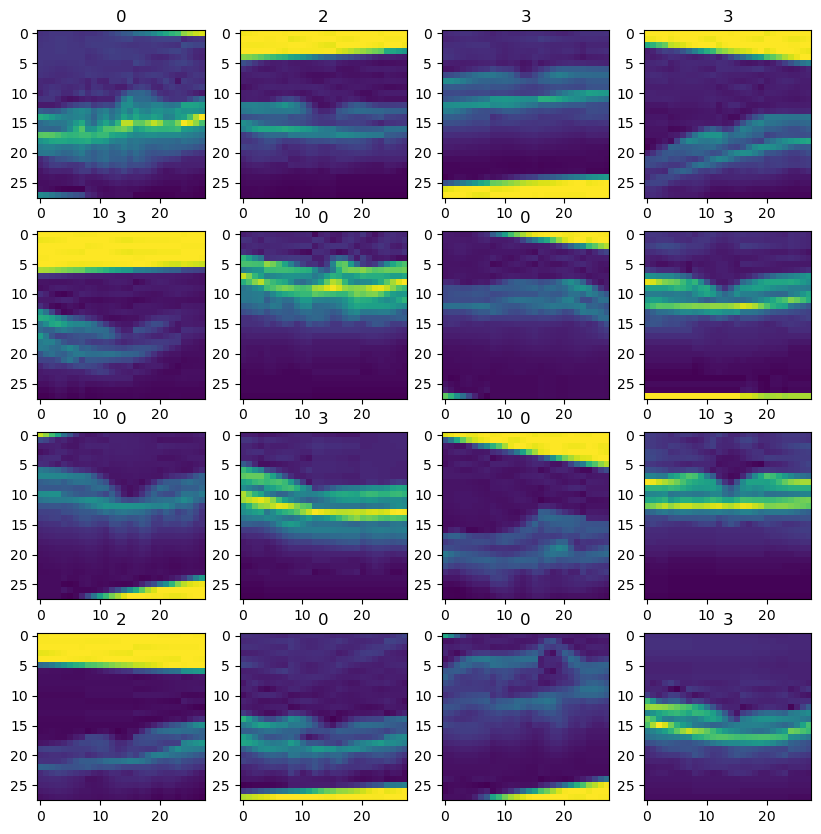

In [8]:
image, label = next(iter(train_dataloader))
print('image shape ', image.shape)
print('label shape ', label.shape)

fig, axes = plt.subplots(4,4, figsize = (10,10))
i = 0
print(x_train.shape)
for r in range(4):
    for c in range(4):
        axes[r,c].imshow(image[i].cpu().numpy().squeeze(0))
        axes[r,c].set_title(label[i].cpu().numpy().squeeze(0))
        i += 1

In [9]:
class EarlyStopper():
    def __init__(self, patience):
        self.attempts = 0
        self.patience = 5
        self.best_accuracy = 0
        self.stop = False
    
    def should_stop(self, model, accuracy):
        if accuracy > self.best_accuracy:
            self.best_accuracy = max(self.best_accuracy, accuracy)
            self.attempts = 0
            #save checkpoint
            torch.save(model, 'nn.checkpoint.h5')
        else:
            self.attempts += 1
            if self.attempts > self.patience:
                self.stop = True
        return self.stop



In [ ]:
#Best model
# model = nn.Sequential(
#     nn.LazyConv2d(16, 5),
#     nn.BatchNorm2d(16),
#     nn.ReLU(),
#     nn.MaxPool2d(2,2),
#     nn.Dropout(0.2),
#     nn.LazyConv2d(32,5),
#     nn.BatchNorm2d(32),
#     nn.ReLU(),
#     nn.MaxPool2d(2,2),
#     nn.Dropout(0.2),
#     nn.Flatten(),
#     nn.LazyLinear(512),
#     nn.ReLU(),
#     nn.LazyLinear(128),
#     nn.ReLU(),
#     nn.LazyLinear(num_class),
# )

In [19]:
model = nn.Sequential(
    nn.LazyConv2d(16, 5),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Dropout(0.2),
    nn.LazyConv2d(32,5),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Dropout(0.2),
    nn.Flatten(),
    nn.LazyLinear(512),
    nn.Sigmoid(),
    nn.LazyLinear(128),
    nn.Sigmoid(),
    nn.LazyLinear(num_class),
)

model.to(DEVICE)
x,y = next(iter(train_dataloader))
print('image shape =', x.shape)
print('label shape = ', y.shape)
summary(model, input_size = x[0].shape)

y_pred = model(x)

optim = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

epochs = 20
history = []

best_score = 0
best_weights = None

def accuracy(model, test_dataloader):
  x,y = next(iter(test_dataloader))
  y = y.cpu().numpy()
  y_pred = model(x)
  y_pred = np.argmax(y_pred.detach().cpu().numpy(), axis = 1)
  return accuracy_score(y, y_pred)

def score_v2(model, test_dataloader, score_fn, **kwargs):
  x,y = next(iter(test_dataloader))
  y = y.cpu().numpy()
  y_pred = model(x)
  y_pred = np.argmax(y_pred.detach().cpu().numpy(), axis = 1)
  return score_fn(y_pred, y, **kwargs)

earlystop = EarlyStopper(patience=5)

for e in range(epochs):
  print("EPOCH = ", e)
  running_loss = 0.0
  saved_checkpoint = False
  for x,y in tqdm(train_dataloader):
    model.train()

    # print(x.shape)
    # print(y.shape)
    y_pred = model(x)
    # print(y_pred.shape)
    loss = criterion(y_pred, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    running_loss += loss.item()

  running_loss_val = 0.0

  for x,y in val_dataloader:
    y_pred = model(x)
    loss = criterion(y_pred, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    running_loss_val += loss.item()

  running_loss_test = 0.0
  for x,y in test_dataloader:
    y_pred = model(x)
    loss = criterion(y_pred, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    running_loss_test += loss.item()

  #measure accuracy
  train_score = accuracy(model, train_dataloader)
  val_score = accuracy(model, val_dataloader)
  test_score = accuracy(model, test_dataloader)


  model.eval()
  if best_score < test_score:
    torch.save({
      'epoch': e,
      'model_state_dict': model.state_dict(),
      'optim_state_dict': optim.state_dict(),
      'train_loss': running_loss,
      'val_loss': running_loss_val,
      'train_accuracy': train_score,
      'val_accuracy': val_score,
    }, 'checkpoint.meta.torch')
    best_score =test_score 
    torch.save(model, 'checkpoint.model.torch')
    saved_checkpoint = True


  print(f'e={e}, loss = {running_loss}, val accuracy = {val_score}, test accuracy = {test_score}' + ('(saved checkpoint}' if saved_checkpoint else ''))
  history.append({
    'train_loss': running_loss, 
    'val_loss': running_loss_val, 
    'test_loss': running_loss_test, 
    'train_accuracy':train_score,
    'val_accuracy':val_score, 
    'test_accuracy':test_score
    })
  
  if earlystop.should_stop(model, val_score):
    break
    

torch.save(model, f'nn.{epochs}epoch.h5')

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


image shape = torch.Size([64, 1, 28, 28])
label shape =  torch.Size([64])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 24]             416
       BatchNorm2d-2           [-1, 16, 24, 24]              32
              ReLU-3           [-1, 16, 24, 24]               0
         MaxPool2d-4           [-1, 16, 12, 12]               0
           Dropout-5           [-1, 16, 12, 12]               0
            Conv2d-6             [-1, 32, 8, 8]          12,832
       BatchNorm2d-7             [-1, 32, 8, 8]              64
              ReLU-8             [-1, 32, 8, 8]               0
         MaxPool2d-9             [-1, 32, 4, 4]               0
          Dropout-10             [-1, 32, 4, 4]               0
          Flatten-11                  [-1, 512]               0
           Linear-12                  [-1, 512]         262,656
          Sigmoid-13         

  0%|          | 0/1524 [00:00<?, ?it/s]

100%|██████████| 1524/1524 [00:50<00:00, 30.36it/s]


e=0, loss = 1026.0375730246305, val accuracy = 0.765625, test accuracy = 0.622(saved checkpoint}
EPOCH =  1


100%|██████████| 1524/1524 [00:50<00:00, 30.10it/s]


e=1, loss = 789.0195848941803, val accuracy = 0.828125, test accuracy = 0.666(saved checkpoint}
EPOCH =  2


100%|██████████| 1524/1524 [00:49<00:00, 30.55it/s]


e=2, loss = 727.1127399355173, val accuracy = 0.859375, test accuracy = 0.653
EPOCH =  3


100%|██████████| 1524/1524 [00:49<00:00, 30.57it/s]


e=3, loss = 686.456231713295, val accuracy = 0.8125, test accuracy = 0.724(saved checkpoint}
EPOCH =  4


100%|██████████| 1524/1524 [00:49<00:00, 30.63it/s]


e=4, loss = 667.4519854485989, val accuracy = 0.875, test accuracy = 0.686
EPOCH =  5


100%|██████████| 1524/1524 [00:49<00:00, 30.79it/s]


e=5, loss = 649.3642603904009, val accuracy = 0.84375, test accuracy = 0.712
EPOCH =  6


100%|██████████| 1524/1524 [00:49<00:00, 30.66it/s]


e=6, loss = 640.9639703035355, val accuracy = 0.828125, test accuracy = 0.682
EPOCH =  7


100%|██████████| 1524/1524 [00:50<00:00, 30.47it/s]


e=7, loss = 635.3191059976816, val accuracy = 0.875, test accuracy = 0.688
EPOCH =  8


100%|██████████| 1524/1524 [00:49<00:00, 30.59it/s]


e=8, loss = 623.2337300553918, val accuracy = 0.859375, test accuracy = 0.68
EPOCH =  9


100%|██████████| 1524/1524 [00:49<00:00, 30.72it/s]


e=9, loss = 619.8195081055164, val accuracy = 0.796875, test accuracy = 0.715
EPOCH =  10


100%|██████████| 1524/1524 [00:49<00:00, 30.77it/s]


e=10, loss = 615.9275121763349, val accuracy = 0.859375, test accuracy = 0.686


### Load best mode

In [20]:
model = torch.load(f'checkpoint.model.torch')

In [21]:
print(history)
train_loss = []
val_loss = []
val_accuracy = []
train_accuracy = []

for data in history:
    train_loss.append(data['train_loss'])
    val_loss.append(data['val_loss'])
    train_accuracy.append(data['train_accuracy'])
    val_accuracy.append(data['val_accuracy'])

[{'train_loss': 1026.0375730246305, 'val_loss': 91.5246040225029, 'test_loss': 0.9918593168258667, 'train_accuracy': 0.734375, 'val_accuracy': 0.765625, 'test_accuracy': 0.622}, {'train_loss': 789.0195848941803, 'val_loss': 79.93923261761665, 'test_loss': 0.8421834707260132, 'train_accuracy': 0.84375, 'val_accuracy': 0.828125, 'test_accuracy': 0.666}, {'train_loss': 727.1127399355173, 'val_loss': 80.17722445726395, 'test_loss': 0.9259846210479736, 'train_accuracy': 0.78125, 'val_accuracy': 0.859375, 'test_accuracy': 0.653}, {'train_loss': 686.456231713295, 'val_loss': 73.3645458072424, 'test_loss': 0.7243812680244446, 'train_accuracy': 0.78125, 'val_accuracy': 0.8125, 'test_accuracy': 0.724}, {'train_loss': 667.4519854485989, 'val_loss': 72.74800169467926, 'test_loss': 0.8248617053031921, 'train_accuracy': 0.90625, 'val_accuracy': 0.875, 'test_accuracy': 0.686}, {'train_loss': 649.3642603904009, 'val_loss': 70.7746709138155, 'test_loss': 0.8297719955444336, 'train_accuracy': 0.90625, '

<Axes: >

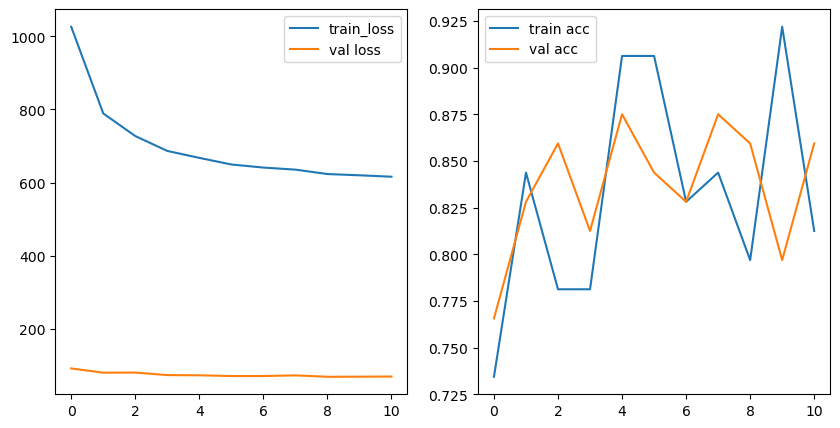

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(train_loss, ax = ax1, label = 'train_loss')
sns.lineplot(val_loss, ax = ax1, label = 'val loss')
sns.lineplot(train_accuracy, ax = ax2, label = 'train acc')
sns.lineplot(val_accuracy, ax = ax2, label = 'val acc')

In [ ]:
# #Load the best model for testing 
# checkpoint = torch.load('checkpoint.torch')
# model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [23]:
x_test, y_test = next(iter(test_dataloader))
y_pred = model(x_test)
y_pred = torch.argmax(y_pred, dim = 1).cpu().numpy()
y_test = y_test.cpu().numpy()
print(y_pred[:10])
print(y_test[:10])
test_score = accuracy(model, test_dataloader)
print(test_score)

[2 0 1 0 2 0 0 0 1 0]
[2 2 3 2 2 0 0 0 1 2]
0.751


[[230  32  81   5]
 [ 15 201   5   3]
 [  4   2  78   7]
 [  1  15  86 235]]


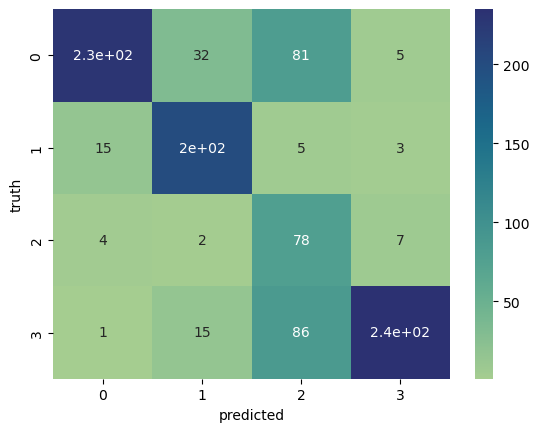

In [24]:
cm = confusion_matrix(y_pred, y_test)
print(cm)
sns.heatmap(cm, annot = True, cmap='crest')
plt.ylabel("truth")
plt.xlabel("predicted")
plt.show()

In [27]:
def get_score(model, dataloader):
    x,y = next(iter(dataloader))
    y = y.cpu().numpy()
    y_pred = model(x)
    y_pred = np.argmax(y_pred.detach().cpu().numpy(), axis = 1)

    print("accuracy = ", accuracy_score(y, y_pred))
    print("precision = ", precision_score(y, y_pred, average = 'weighted'))
    print("recal = ", recall_score(y, y_pred, average = 'weighted'))
    print("f1 = ", f1_score(y, y_pred, average = 'weighted'))

print('training')
get_score(model, train_dataloader)
print()
print("validation")
get_score(model, val_dataloader)
print()
print('test')
get_score(model, test_dataloader)


training
accuracy =  0.90625
precision =  0.9110991379310345
recal =  0.90625
f1 =  0.9062017581475128

validation
accuracy =  0.890625
precision =  0.895673076923077
recal =  0.890625
f1 =  0.8919955201734864

test
accuracy =  0.75
precision =  0.7817587663441418
recal =  0.75
f1 =  0.7227752580884748
